# Eliminate experimental data such as battery charging and discharging.

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat


def raw_data_read(file_path, battery_name):
  mat = loadmat(file_path+battery_name+'.mat')
  flag = 1  #用于记录上一数据类型，0代表充电，1代表放电。初始为1，为了从充电数据开始记录。
  print('Load data from: ', file_path+battery_name+'.mat ...')

  charge_current = []
  charge_voltage = []
  charge_time = []
  charge_temp = []

  discharge_time = []
  discharge_temp = []
  discharge_current = []
  discharge_voltage = []

  Capacity = []

  for i in range(len(mat[battery_name][0,0]['cycle'][0])):  #电池测试次数，包括（充电、放电、阻抗测试）
    if i < 3:
      # 跳过第一个充放电周期
      continue
    if i == 615:
      break
    #首先读取cycle的数据，包括type、ambient_temperature、time、data
    row = mat[battery_name][0, 0]['cycle'][0, i]       #每个测试的数据，只有放电数据有容量值
    cycle_type = row['type'][0] # charge\discharge\impedence
    data = row['data'][0][0]

    if (cycle_type == 'charge')&(flag == 1):
      flag = 0
      #去除每个周期中前两个值，脉冲噪声
      c_m_voltage = data['Voltage_measured'][0][2:] #终端电压，需要找到>4.2V的第一个值及其时间
      c_m_current = data['Current_measured'][0][2:] #输出电流，需要找到<1.5A
      c_temp = data['Temperature_measured'][0][2:] #温度
      c_time = data['Time'][0][2:]          #时间

      # 删除恒压充电后，电池静置产生的数据。 恒压充电结束的设定是电流降至20mA以下。
      for i in range(len(c_m_current)):
        if c_m_current[i] < 0.02:
          c_m_voltage = c_m_voltage[:i]
          c_m_current = c_m_current[:i]
          c_temp = c_temp[:i]
          c_time = c_time[:i]
          break

      charge_current.append(c_m_current)
      charge_voltage.append(c_m_voltage)
      charge_temp.append(c_temp)
      charge_time.append(c_time)

    elif (cycle_type == 'discharge')&(flag == 0):
      flag = 1
      # 去除每个周期中前两个值，脉冲噪声
      d_m_voltage = data['Voltage_measured'][0][2:] #终端电压，需要找到>4.2V的第一个值及其时间
      d_m_current = data['Current_measured'][0][2:] #输出电流，需要找到<1.5A
      d_temp = data['Temperature_measured'][0][2:] #温度
      d_time = data['Time'][0][2:]          #时间

      # # 删除到达放点截止电压后的数据
      # dis_vol_thresh = {'B0005':2.7, 'B0006':2.5, 'B0007':2.2, 'B0018':2.5}
      # k = np.argmin(abs(d_m_voltage - np.array(dis_vol_thresh[battery_name])))
      # d_m_voltage = d_m_voltage[:k+1]
      # d_m_current = d_m_current[:k+1]
      # d_temp = d_temp[:k+1]
      # d_time = d_time[:k+1]


      # # 删除放电后，电池静置产生的数据
      # for i in range(len(d_m_voltage)):
      #   if i == len(d_m_voltage)-1:
      #     break
      #   if d_m_voltage[i+1] > d_m_voltage[i]:
      #     d_m_voltage = d_m_voltage[:i+1]
      #     d_m_current = d_m_current[:i+1]
      #     d_temp = d_temp[:i+1]
      #     d_time = d_time[:i+1]
      #     break

      Capacity.append(data['Capacity'][0][0])
      discharge_time.append(d_time)
      discharge_temp.append(d_temp)
      discharge_voltage.append(d_m_voltage)
      discharge_current.append(d_m_current)

  return (charge_voltage, charge_current, charge_temp, charge_time,
      discharge_time, discharge_voltage, discharge_temp, discharge_current, Capacity)

file_path = ''  # '/content/AutoEncoder-CNN-LSTM--to-prediction-battery-RUL/NASA_PCoE-Datasets_Battery/'
battery_list = ['B0005', 'B0006', 'B0007', 'B0018']

""" Save different battery data separately. """
# data_save_path = './data/'
# if not os.path.exists(data_save_path):
#     os.makedirs(data_save_path)
#
# for id in battery_list:
#     # only save the capacity
#     data = raw_data_read(file_path, id)
#     data = np.array([range(1, len(data[-1])+1), data[-1]]).transpose()
#     data = pd.DataFrame(data, columns=['cycle', 'capacity'])
#     data.to_csv(data_save_path + id+'.csv', index=False)
#     print('Save Dataset to ' + data_save_path + id + '.csv ...')

""" Save all battery data to the same file. """
data = []
for id in battery_list:
    data_temp = raw_data_read(file_path, id)
    data.append(pd.Series(data_temp[-1], name=id))
data = pd.concat(data, axis=1)
data.to_csv('data.csv', index=False)



Load data from:  B0005.mat ...
Load data from:  B0006.mat ...
Load data from:  B0007.mat ...
Load data from:  B0018.mat ...


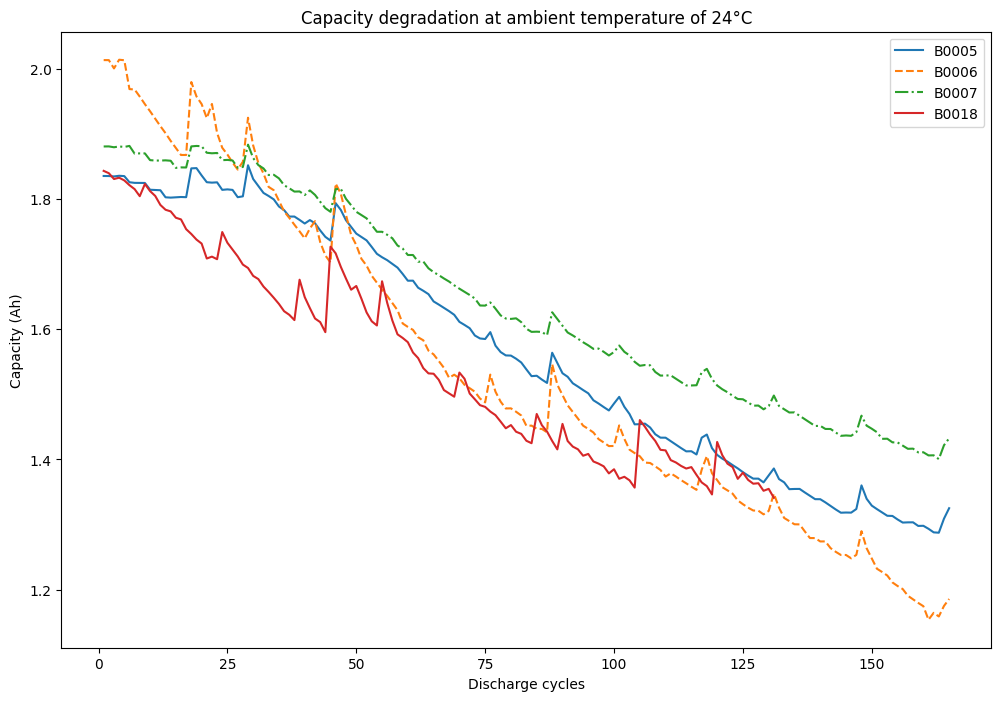

In [33]:
import matplotlib.pyplot as plt

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = []
for id in Battery_list:
    data = pd.read_csv(data_save_path + id+'.csv')
    Battery.append([data['cycle'], data['capacity']])

fig, ax = plt.subplots(1, figsize=(12, 8))
line_list = ['solid', 'dashed', 'dashdot', 'solid']

for i,name in enumerate(Battery_list):
    df_result = Battery[i]
    ax.plot(df_result[0], df_result[1], label=name, linestyle=line_list[i])
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

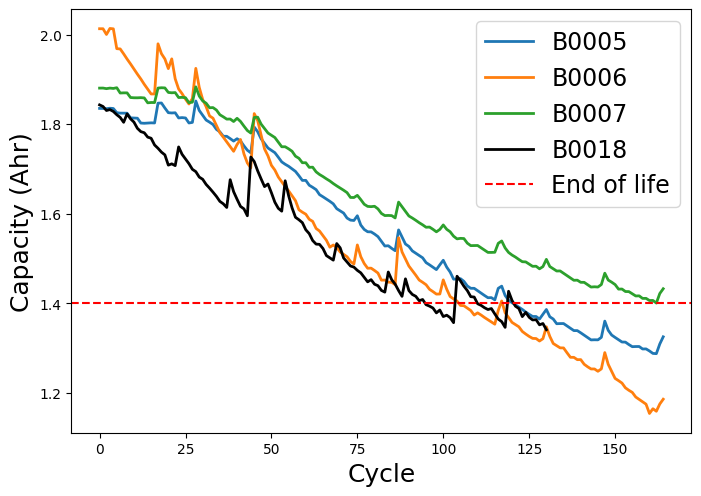

In [18]:
import matplotlib.pyplot as plt

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
data = pd.read_csv('data.csv')

fig, ax = plt.subplots(1, figsize=(8, 5.5))

for name in Battery_list[:3]:
    ax.plot(data[name], label=name, linewidth=2)
ax.plot(data[Battery_list[-1]], label=Battery_list[-1], linewidth=2, color='black')
ax.axhline(y=1.4, color='r', linestyle='--', label='End of life')
plt.xlabel('Cycle', fontsize=18)
plt.ylabel('Capacity (Ahr)', fontsize=18)
plt.legend(fontsize=17)
plt.savefig('capacity.png', dpi=300, bbox_inches='tight')